# Przetwarzanie danych

In [1]:
from sklearn.preprocessing import StandardScaler
from skfuzzy.cluster import cmeans, cmeans_predict
from sklearn.metrics import pairwise_distances_argmin_min
from sktime.datasets import load_basic_motions, load_arrow_head
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff

### Parametry startowe programu

In [2]:
chunk_length_train = 400
chunk_length_test = 400
std_div = 30
n_clusters = 11
dim = 6
injection = 1.0
injection_power = 0.8
m = 2.0
g_error = 0.05

### Dane

In [3]:
%cd ..

D:\FuzzyC\FuzzyClusteringAlgorithms


### Pobieranie danych z biblioteki sktime

In [4]:
# load an example time series panel in numpy mtype Numpy 2D
X_train, y_train = load_basic_motions(split="train", return_type="numpy2D")
X_test, y_test =  load_basic_motions(split="test", return_type="numpy2D")

In [5]:
# load an example time series panel in numpy mtype Numpy 3D
X_train, y_train = load_basic_motions(split="train", return_type="numpy3D")
X_test, y_test =  load_basic_motions(split="test", return_type="numpy3D")

### Importowanie danych z dysku

In [6]:
from libraries.load import load_dataset_to_dataframe

filepath_train = './datasets/BasicMotions/BasicMotions_TRAIN.arff'
filepath_test = './datasets/BasicMotions/BasicMotions_TEST.arff'

df_train = load_dataset_to_dataframe(filepath_train)
df_test = load_dataset_to_dataframe(filepath_test)

In [7]:
from libraries.segmentation import stack_time_series, stack_time_series_randomly

stacked_train, _ , y_train = stack_time_series_randomly(df_train)
stacked_test, _ , y_test = stack_time_series_randomly(df_test)
#stacked_train, y_train = stack_time_series(df_train)
#stacked_test, y_test = stack_time_series(df_test)

In [8]:
def stack_columns(stacked_train):
    result = stacked_train.loc[0,0]
    
    for i in range(1,stacked_train.shape[0]):
        result = np.column_stack((result, stacked_train.loc[i,0]))
    return result
    
X_train = stack_columns(stacked_train)
X_test = stack_columns(stacked_test)

In [9]:
def extend_list(lista, n):
    wynik = []
    for element in lista:
        wynik.extend([element] * n)
    return wynik

y_test_extended = extend_list(y_test, 100)
y_train_extended = extend_list(y_train, 100)

In [10]:
def map_strings_to_ints(strings):
    # Utwórz słownik do mapowania stringów na inty
    string_to_int = {}
    current_int = 0
    
    # Wynikowa lista z intami
    result = []
    
    # Przejdź przez listę stringów
    for string in strings:
        # Jeśli string nie jest jeszcze w słowniku, dodaj go
        if string not in string_to_int:
            string_to_int[string] = current_int
            current_int += 1
        # Dodaj odpowiadający int do wynikowej listy
        result.append(string_to_int[string])
    
    return result

y_train = map_strings_to_ints(y_train_extended)
y_test = map_strings_to_ints(y_test_extended)

## Genrowanie syntetycznych danych

### Generowanie danych syntetycznych sinusoidalnych

In [11]:
from libraries.generate_datasets import generate_multidimensional_sine_data, generate_dataset_blobs

# Parametry
num_dimensions = 6  # liczba wymiarów 
frequency = 1  # częstotliwość
amplitude = 1  # amplituda
phase = [0, np.pi/4, np.pi/2, 0, 0, 0]  # fazy początkowe dla każdego wymiaru
duration = 50  # czas trwania sygnału
sampling_rate = 100  # liczba próbek na jednostkę czasu
noise_std = 0.2  # odchylenie standardowe szumu
num_classes = n_clusters

In [12]:
# Generowanie danych
#t_train, X_train, y_train_extended_list = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)
#t_test, X_test, y_test_extended = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)

### Generowanie plam

In [13]:
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_blobs(n=3000,c=dim,k=n_clusters,seed=42)

### Generowanie prostych

In [14]:
from libraries.generate_datasets import generate_dataset_lines

# Parametry linii prostych
a_values = [2, 2, 2]  # Współczynniki a dla różnych składowych
b_values = [1, 10, 20]      # Współczynniki b dla różnych składowych
num_points = 5000           # Liczba punktów danych
std_dev = 0.1     # Odchylenie standardowe dla szumu

In [15]:
#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_lines(a_values, b_values, num_points = num_points, std_dev = std_dev, n_clusters = n_clusters)

## Processing danych

### Tasowanie danych

In [16]:
# Zwykłe tasowanie punktów.
def shuffle_data(X, y):
    
    # Sprawdzenie czy liczba wierszy w X odpowiada liczbie elementów w y
    assert X.shape[0] == len(y), "Liczba wierszy w X musi odpowiadać liczbie elementów w y"
    
    # Losowanie indeksów
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    # Przemieszanie X i y zgodnie z wylosowanymi indeksami
    X_shuffled = X[indices]
    y_shuffled = np.array(y)[indices].tolist()
    
    return X_shuffled, y_shuffled

def sort_by_class(X, y):
    # Sortowanie według etykiet w y
    sorted_indices = np.argsort(y)
    
    # Zastosowanie posortowanych indeksów do X i y
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]
    
    return X_sorted, y_sorted

# Dzieli dane dla każdej klasy na odcinki średniej długości mean  z odchyleniem standardowym std_var. Następnie tasuje tak stworzone segmenty.
def shuffle_dataset_with_chunk_sizes(X, y, mean, std_var):
    # Liczba klas
    num_classes = np.unique(y).size
    y = np.array(y)
    # Listy do przechowywania chunków i etykiet
    X_chunks = []
    y_chunks = []
    chunk_sizes_list = []

    # Ustalanie rozmiaru chunków i mieszanie w obrębie każdej klasy
    start = 0
    for i in range(num_classes):
        # Wyodrębnij dane dla danej klasy
        class_indices = np.where(y == i)[0]
        class_size = len(class_indices)
        
        # Losowanie chunków
        chunk_sizes = []
        while sum(chunk_sizes) < class_size:
            chunk_size = int(np.abs(np.random.normal(mean, std_var)))
            if sum(chunk_sizes) + chunk_size > class_size:
                chunk_size = class_size - sum(chunk_sizes)
            chunk_sizes.append(chunk_size)
        
        # Dzielenie i mieszanie chunków
        class_X_chunks = np.array_split(X[class_indices], np.cumsum(chunk_sizes[:-1]))
        class_y_chunks = np.array_split(y[class_indices], np.cumsum(chunk_sizes[:-1]))
        
        X_chunks.extend(class_X_chunks)
        y_chunks.extend(class_y_chunks)
        chunk_sizes_list.extend(chunk_sizes)

    # Mieszanie w skali całego datasetu
    combined = list(zip(X_chunks, y_chunks, chunk_sizes_list))
    np.random.shuffle(combined)
    
    # Rozdzielenie pomieszanych chunków
    X_shuffled, y_shuffled, shuffled_chunk_sizes = zip(*combined)
    
    # Spłaszczenie listy chunków
    X_shuffled = np.concatenate(X_shuffled)
    y_shuffled = np.concatenate(y_shuffled)

    return X_shuffled, y_shuffled, list(shuffled_chunk_sizes)

X_train, y_train, chunk_train_sizes = shuffle_dataset_with_chunk_sizes(X_train, y_train, chunk_length_train, std_div)
X_test, y_test, chunk_test_sizes = shuffle_dataset_with_chunk_sizes(X_test, y_test, chunk_length_test, std_div)

### Wizualizacja danych

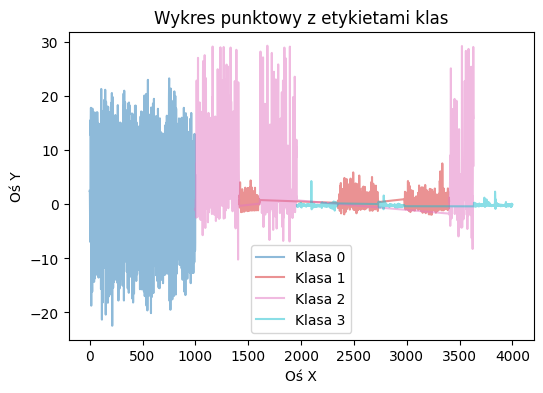

In [17]:
def show_labels_of_dataset(X, y):
  # Ustalamy unikalne etykiety
    unique_labels = np.unique(y)
    
    # Wybieramy kolory dla każdej klasy
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    # Tworzenie wykresu punktowego
    plt.figure(figsize=(6, 4))
    
    for i, label in enumerate(unique_labels):
        # Wybieranie punktów dla danej klasy
        ix = np.array(np.where(label == y)).reshape(-1)
        mask = (y == label)
        plt.plot(ix, X[mask, 0], color=colors[i], label=f'Klasa {label}', alpha=0.5)
    
    # Dodanie tytułu i etykiet osi
    plt.title('Wykres punktowy z etykietami klas')
    plt.xlabel('Oś X')
    plt.ylabel('Oś Y')
    
    # Dodanie legendy
    plt.legend()
    
    # Wyświetlenie wykresu
    plt.show()

show_labels_of_dataset(X_train, y_train)

In [18]:
# Visualise Loaded Data
def visualise_loaded_data(data):
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Plot different data on each subplot
    axs[0, 0].plot(data[:,0])
    axs[0, 0].set_title('accelerometer X')

    axs[0, 1].plot(data[:,1])
    axs[0, 1].set_title('accelerometer Y')

    axs[0, 2].plot(data[:,2])
    axs[0, 2].set_title('accelerometer Z')

    axs[1, 0].plot(data[:,3])
    axs[1, 0].set_title('gyroscope X')

    axs[1, 1].plot(data[:,4])
    axs[1, 1].set_title('gyroscope Y')

    axs[1, 2].plot(data[:,5])
    axs[1, 2].set_title('gyroscope Z')

    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()

# Visualise Loaded Data
def visualise_loaded_data(data):
    # Create a 2x3 grid of subplots
    c = data.shape[1]
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(c):
        # Plot different data on each subplot
        axs[int(i/3), i%3].plot(data[:,i])
        axs[int(i/3), i%3].set_title(f'param {i}')
        
    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()

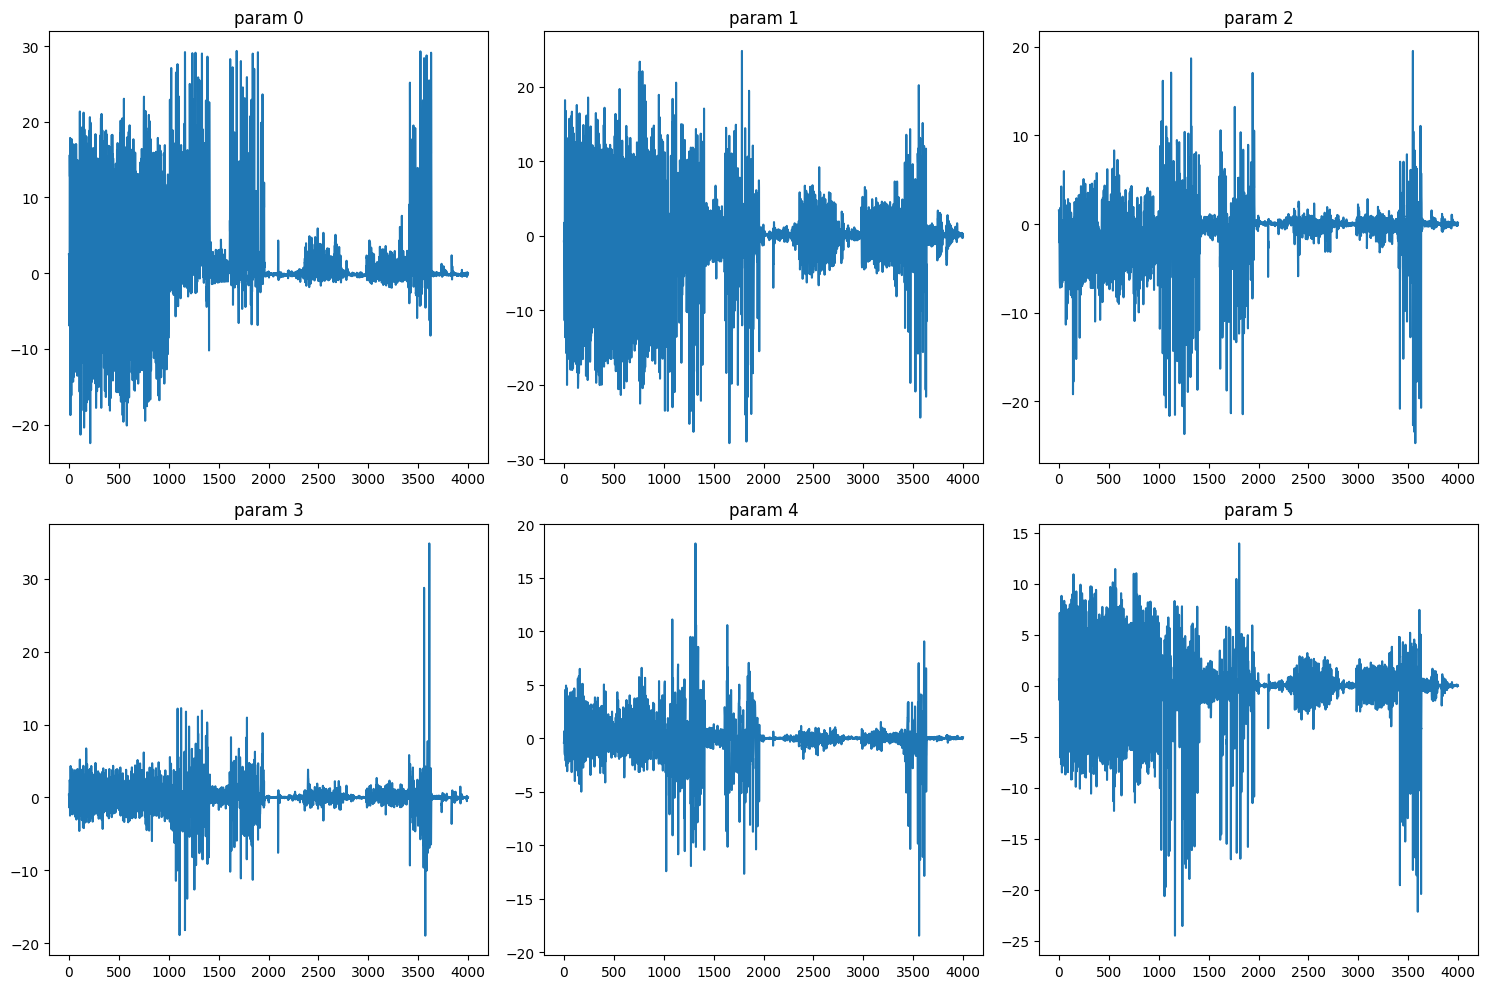

In [19]:
visualise_loaded_data(X_train)

### Punkty inicjalizacyjne i macierze semi_supervised

In [20]:
# Dla każdej klasy znajdź punkt średni.
def average_by_class(X, y):
    # Unikalne klasy w y
    classes = np.unique(y)
    
    # Słownik do przechowywania średnich dla każdej klasy
    class_averages = {}
    
    for cls in classes:
        # Wybieramy indeksy odpowiadające danej klasie
        indices = np.where(y == cls)
        
        # Wybieramy punkty z X odpowiadające danej klasie
        class_points = X[indices]
        
        # Obliczamy średnią dla danej klasy
        class_avg = np.mean(class_points, axis=0)
        
        # Dodajemy średnią do słownika
        class_averages[cls] = class_avg
    
    return class_averages


In [21]:
# Tworzy clustry na podstawie średnich punktów dla każdej klasy. Dla każdej klasy generuje kilka punktów z lekkim odchyleniem od średniego punktu dla danej klasy.
# Punkty wygenerowane sumują się do n_clusters.
def generate_clusters_proportional(average_points, n_clusters, deviation=0.1):
    """
    average_points: słownik zawierający średnie punkty dla każdej klasy
    n_clusters: łączna liczba punktów do wygenerowania dla wszystkich klas
    deviation: maksymalne odchylenie od średniej, domyślnie 0.1 (10%)
    
    Zwraca: słownik zawierający generowane punkty dla każdej klasy
    """
    # Liczba klas
    num_classes = len(average_points)
    
    # Początkowy przydział punktów do klas (podział równomierny)
    points_per_class = [n_clusters // num_classes] * num_classes
    
    # Jeśli n_clusters nie jest podzielne przez num_classes, rozdysponuj pozostałe punkty
    remainder = n_clusters % num_classes
    for i in range(remainder):
        points_per_class[i] += 1
    
    # Generowanie punktów dla każdej klasy
    generated_points = []

    # Dla każdego centroida przyporządkowana informacja o klasie
    class_of_centroid = []

    # Dla każdej klasy zwraca listę centroidów (jeden bądź wiele punktów)
    clusters_for_each_class = {}
    indicies_start = 0
    
    for i, (cls, avg_point) in enumerate(average_points.items()):
        # Liczba punktów do wygenerowania dla danej klasy
        points_count = points_per_class[i]
        
        # Tworzymy losowe odchylenie dla każdego wymiaru
        deviations = np.random.randn(points_count, avg_point.size) * deviation
        
        # Generujemy punkty z lekkim odchyleniem od średniej
        points = avg_point + deviations

        clusters_for_each_class[cls] = range(indicies_start,indicies_start + points_per_class[i])
        
        indicies_start += points_per_class[i]
        # Przechowujemy wygenerowane punkty w słowniku
        for point in points:
            generated_points.append(point)
            class_of_centroid.append(cls)
    
    return np.array(generated_points), np.array(class_of_centroid), clusters_for_each_class


In [22]:
# Metoda tworząca z wektora labelów tablicę labelów potrzebną do implementacji algorytmu SSFCM.
def label_vector_to_semi_supervised_matrix(y, n_clusters, clusters_for_each_class,  procent_of_data=0.5):
    array = np.zeros((len(y), n_clusters))

    for i, label in enumerate(y):
        if(i >= len(y)*procent_of_data):
            break

        injection_power = 1 / len(clusters_for_each_class[label]) - 0.5
        for element in clusters_for_each_class[label]:
            array[i, element] = injection_power
            
    return array

# Tworzy macierz do uczenia nadzorowanego. Przydziela kilka klastrów do danej klasy.
# Injection to procent danych jakie labelujemy
# Zwraca punkty stworzone przez funkcje generate_clusters_proportional.
def create_semi_supervised_matrix(X, y, n_clusters, injection=injection):

    average_classes = average_by_class(X, y)

    init_centroids, class_of_centroid, clusters_for_each_class = generate_clusters_proportional(average_classes, n_clusters, deviation=0.1)

    y_matrix = label_vector_to_semi_supervised_matrix(y_train, n_clusters, clusters_for_each_class, injection)

    return y_matrix, init_centroids

y_train_matrix, init_centroids = create_semi_supervised_matrix(X_train, y_train, n_clusters)

### Tworzenie chunków

In [23]:
def create_chunks(chunk_sizes, X, y, y_matrix=None):
    # Rozmiary kolejnych chunków, mogą mieć różne wielkości. Następnie ze względu na te liczby dzielone są chunki
    #chunk_sizes = [chunk_length for i in range(0,int(X_train.shape[0]/chunk_length))]
    chunks = []
    chunks_y = []
    chunks_y_matrix = []
    start = 0
    for size in chunk_sizes:
        end = start + size
        chunks.append(X[start:end])
        chunks_y.append(y[start:end])
        if y_matrix is not None:
            chunks_y_matrix.append(y_matrix[start:end])
        start = end

    return chunks, chunks_y, chunks_y_matrix

chunks, chunks_y, chunks_y_matrix = create_chunks(chunk_train_sizes, X_train, y_train, y_train_matrix)
chunks_test, chunks_test_y, _ = create_chunks(chunk_test_sizes, X_test, y_test)

### Wyświetlanie chunków

In [24]:
# import matplotlib.pyplot as plt

# def plot_class_chunks(chunks, chunks_y, class_num):
#     """
#     Wizualizuje chunki danych dla określonej klasy, plotując każdy wymiar danych jako wykres liniowy.

#     Args:
#         chunks (list of numpy.ndarray): Lista chunków danych (każdy chunk to podzbiór danych).
#         chunks_y (list of numpy.ndarray): Lista etykiet odpowiadających chunkom.
#         class_num (int): Numer klasy, którą chcemy zwizualizować.
    
#     Returns:
#         None
#     """

#     # Zbieranie danych i etykiet dla wybranej klasy
#     selected_chunks = []
#     for i, chunk_y in enumerate(chunks_y):
#         if np.all(chunk_y == class_num):  # Sprawdzamy, czy wszystkie etykiety w chunku to `class_num`
#             selected_chunks.append(chunks[i])
#             break
    
#     # Sprawdzenie, czy są chunki dla podanej klasy
#     if len(selected_chunks) == 0:
#         print(f"Brak chunków dla klasy {class_num}.")
#         return
    
#     # Łączenie wszystkich wybranych chunków w jedną macierz
#     data_to_plot = np.vstack(selected_chunks)
    
#     # Tworzenie wykresu dla każdego wymiaru danych
#     num_dimensions = data_to_plot.shape[1]
#     fig, axs = plt.subplots(num_dimensions, 1, figsize=(10, 5 * num_dimensions))
    
#     # Jeśli mamy tylko jeden wymiar, axs jest pojedynczą osią, a nie listą
#     if num_dimensions == 1:
#         axs = [axs]
    
#     for i in range(num_dimensions):
#         axs[i].plot(range(data_to_plot.shape[0]), data_to_plot[:, i], label=f'Wymiar {i+1}', alpha=0.7)
#         axs[i].set_title(f'Klasa {class_num} - Wymiar {i+1}')
#         axs[i].set_xlabel('Indeks punktu')
#         axs[i].set_ylabel(f'Wartość wymiaru {i+1}')
#         axs[i].legend()
    
#     plt.tight_layout()
#     plt.show()

# # Przykład użycia funkcji:
# #plot_class_chunks(chunks, chunks_y, class_num=2)

# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# def plot_class_chunks(chunks, chunks_y, class_num, n_components=2):
#     """
#     Wizualizuje chunki danych dla określonej klasy za pomocą PCA, kolorując każdy chunk innym kolorem.
#     Dodatkowo rysuje wszystkie pozostałe chunki w jednym kolorze.

#     Args:
#         chunks (list of numpy.ndarray): Lista chunków danych (każdy chunk to podzbiór danych).
#         chunks_y (list of numpy.ndarray): Lista etykiet odpowiadających chunkom.
#         class_num (int): Numer klasy, którą chcemy zwizualizować.
#         n_components (int): Liczba komponentów PCA (domyślnie 2).
    
#     Returns:
#         None
#     """

#     # Zbieranie danych i etykiet dla wybranej klasy oraz pozostałych klas
#     selected_chunks = []
#     other_chunks = []
#     counter = 0 
#     for i, chunk_y in enumerate(chunks_y):
#         if np.all(chunk_y == class_num):  # Sprawdzamy, czy wszystkie etykiety w chunku to `class_num`
#             #if counter == 2:
#             selected_chunks.append(chunks[i])
#             counter += 1
#         else:
#             other_chunks.append(chunks[i])
    
#     # Łączenie wszystkich wybranych chunków w jedną macierz
#     if len(selected_chunks) == 0:
#         print(f"Brak chunków dla klasy {class_num}.")
#         return
    
#     data_to_plot = np.vstack(selected_chunks)
#     other_data = np.vstack(other_chunks) if len(other_chunks) > 0 else None
    
#     # Redukcja wymiarów za pomocą PCA
#     pca = PCA(n_components=n_components)
#     pca.fit(np.concatenate(chunks))  # PCA na wszystkich danych
#     reduced_data = pca.transform(data_to_plot)
#     reduced_other_data = pca.transform(other_data) if other_data is not None else None
    
#     # Tworzenie wykresu
#     plt.figure(figsize=(10, 8))
    
#     # Kolory dla różnych chunków wybranej klasy
#     colors = plt.cm.get_cmap('tab10', len(selected_chunks))
    
#     # Rysowanie chunków wybranej klasy
#     start_idx = 0
#     for i, chunk in enumerate(selected_chunks):
#         end_idx = start_idx + len(chunk)
#         plt.scatter(reduced_data[start_idx:end_idx, 0], reduced_data[start_idx:end_idx, 1], 
#                     label=f'Chunk {i+1} (Class {class_num})', color=colors(i), alpha=0.7)
#         start_idx = end_idx
    
#     # Rysowanie chunków pozostałych klas w jednym kolorze
#     if reduced_other_data is not None:
#         plt.scatter(reduced_other_data[:, 0], reduced_other_data[:, 1], 
#                     label=f'Other Classes', color='gray', alpha=0.5)
    
#     # Dodanie tytułu i etykiet osi
#     plt.title(f'PCA dla klasy {class_num}')
#     plt.xlabel('Pierwsza składowa PCA')
#     plt.ylabel('Druga składowa PCA')
#     plt.legend()
    
#     # Wyświetlenie wykresu
#     plt.show()

# # Przykład użycia funkcji:


# plot_class_chunks(chunks, chunks_y, class_num=2)


# Metody klastrujące biblioteczne

### Fuzzy cmeans

# Algorytm ISSFCM

In [25]:
from scipy.spatial.distance import cdist
from libraries.diagnosis_tools import DiagnosisTools, Multilist
from libraries.IFCM import incremental_fuzzy_cmeans_predict

### Algorytm semi-nadzorowany inkrementacyjny

##### Normalizowanie kolumn

In [26]:
import numpy as np

def normalize_columns(columns):
    # broadcast sum over columns
    normalized_columns = columns/np.sum(columns, axis=0, keepdims=1)

    return normalized_columns

def reflect_labels(y):
    result = 1 - np.sum(y, axis=0, keepdims=1)
    
    return result

def normalize_power_columns(x, exponent):
    assert np.all(x >= 0.0)

    x = x.astype(np.float64)

    # values in range [0, 1]
    x = x/np.max(x, axis=0, keepdims=True)

    # values in range [eps, 1]
    x = np.fmax(x, np.finfo(x.dtype).eps)

    if exponent < 0:
        # values in range [1, 1/eps]
        x /= np.min(x, axis=0, keepdims=True)

        # values in range [1, (1/eps)**exponent] where exponent < 0
        # this line might trigger an underflow warning
        # if (1/eps)**exponent becomes zero, but that's ok
        x = x**exponent
    else:
        # values in range [eps**exponent, 1] where exponent >= 0
        x = x**exponent

    result = normalize_columns(x)

    return result



##### Trening

In [27]:
from scipy.spatial.distance import cdist
from libraries.diagnosis_tools import DiagnosisTools, Multilist

def choose_random_rows(array, c):
    if c > array.shape[0]:
        raise ValueError("Liczba wierszy do wybrania jest większa niż liczba dostępnych wierszy w tablicy.")
    
    # Wybór c unikalnych indeksów wierszy
    row_indices = np.random.choice(array.shape[0], c, replace=False)
    
    # Wybranie wierszy o wybranych indeksach
    selected_rows = array[row_indices]
    
    return selected_rows
    
def initialize_c_first_centroids(data, c):
    # Inicjalizuje biorąc pierwsze k punktów jako centroidy
    selected_rows = choose_random_rows(data, c)
    return selected_rows

def initialize_average_c_centroids(data, y_train, c):
    # Oblcza dla każdego segmentu średnią liczbę punktów
    return data[0:c,:]
    
def create_labels_s(data, y, centroids, metric, m):
    # Tablica dystansów
    dist = _distance(data, centroids, metric)

    # Tablica prawdopodobieństw z zwykłego algorytmu FCM
    fuzzy_labels = normalize_power_columns(dist, - 2. / (m - 1))

    # 1 - sum j = 1:C y(j)
    y_ = reflect_labels(y)
    y_ = np.tile(y_, (fuzzy_labels.shape[0], 1))

    fuzzy_labels = y + np.multiply(fuzzy_labels, y_)
    
    return fuzzy_labels

def _fp_coeff(u):
    # Mierzy rozmytość wyliczonych klastrów
    n = u.shape[1]
    
    return np.trace(u.dot(u.T)) / float(n)

def _distance(data, centroids, metric='euclidean'):
    # Oblicza dystans dla każdego punktu do każdego centroidu
    dist = cdist(data, centroids, metric=metric).T
    
    return np.fmax(dist, np.finfo(np.float64).eps)

def semi_supervised_cmeans0(data, y, centroids, metric, c, m):
    # Obliczanie tablicy dystansów
    dist = _distance(data, centroids, metric)

    # Obliczanie fuzzy_labels na podstawie centroidów i tablicy dystansów
    fuzzy_labels = create_labels_s(data, y, centroids, metric, m)

    fuzzy_labels_supervised = abs(fuzzy_labels - y)
    
    fuzzy_labels_supervised_m = fuzzy_labels_supervised ** m
    
    # Aktualizowanie centroidów
    centroids = fuzzy_labels_supervised_m.dot(data) / np.atleast_2d(fuzzy_labels_supervised_m.sum(axis=1)).T

    jm = (fuzzy_labels_supervised_m * dist ** 2).sum()
    
    return centroids, fuzzy_labels, jm, dist


def incremental_semi_supervised_fuzzy_cmeans(data, y, c, m, error, maxiter, metric = 'euclidean', init_centroid=None):
    # data jeste postaci (n_samples, k_features)
    # Rozmiar danych
    n = data.shape[0]
    
    # Liczba clustrów
    k = data.shape[1]
    
    # Struktura do której bedziemy zbierać informacje z każdej iteracji
    statistics = Multilist(['fpc'])
    
    centroids = init_centroid
    
    if(init_centroid is None):
        centroids = initialize_c_first_centroids(data, c)
        #centroids = initialize_average_c_centroids(data, y_train, k)
    
    fuzzy_labels = create_labels_s(data, y.T,  centroids, metric, m)

    # Initialize loop parameters
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        fuzzy_labels_copy = fuzzy_labels.copy()
        centroids_copy = centroids.copy()

        [centroids, fuzzy_labels, Jjm, dist] = semi_supervised_cmeans0(data, y.T, centroids_copy, metric, c, m)

        fpc = _fp_coeff(fuzzy_labels)
        statistics.add_elements([fpc])
        p += 1
        
        # Stopping rule
        if np.linalg.norm(fuzzy_labels - fuzzy_labels_copy) < error and p > 1:
            break
        if np.linalg.norm(centroids_copy - centroids) < error and p > 1:
            break
            
    # Final calculations
    error = np.linalg.norm(fuzzy_labels - fuzzy_labels_copy)
    fpc = _fp_coeff(fuzzy_labels)

    return centroids, fuzzy_labels, dist, p, fpc, statistics


##### Predykcja

In [28]:
def incremental_semi_supervised_fuzzy_cmeans_predict(test_data, cntr_trained, m, error, maxiter, metric='euclidean', init=None, seed=None):
    c = cntr_trained.shape[0]

    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = test_data.shape[1]
        u0 = np.random.rand(c, n)
        u0 = normalize_columns(u0)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [u, Jjm, d] = incremental_semi_supervised_cmeans_predict0(test_data, cntr_trained, u2, c, m, metric)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return u, u0, d, jm, p, fpc 
    
def incremental_semi_supervised_cmeans_predict0(test_data, cntr, u_old, c, m, metric):

    # Normalizing, then eliminating any potential zero values.
    u_old = normalize_columns(u_old)
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m
    test_data = test_data.T

    # For prediction, we do not recalculate cluster centers. The test_data is
    # forced to conform to the prior clustering.

    d = _distance(test_data, cntr, metric)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d ** 2).sum()

    u = normalize_power_columns(d, - 2. / (m - 1))

    return u, jm, d

# Algorytm DISSFCM

# Metody wizualizacji danych

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import random

### Redukcja wymiarowości

In [30]:
def simple_plot(X, cntr, cluster_labels, name):
    n_clusters = cntr.shape[0]
    if X.shape[1] > 2:
        # Jeżeli dane mają więcej niż 2 wymiary, to można redukować ich wymiarowość. 
        # Zwracamy zatem True, aby użyć algorytmu redukującego wymiarowość
        return True
    
    elif X.shape[1] == 2:
        # Tworzymy wykres dla danych 2 wymiarowych
        # Wizualizacja klastrów
        plt.figure(figsize=(10, 8))
        for i in range(n_clusters):
            plt.scatter(X[cluster_labels == i, 0], X[cluster_labels == i, 1], label=f'Cluster {i+1}')
    
        # Dodanie centrów klastrów do wykresu
        plt.title('Fuzzy C-Means Clustering 2D ' + name)
        plt.scatter(cntr[:, 0], cntr[:, 1], marker='x', s=200, c='black', label='Cluster Centers')
    
    elif X.shape[1] == 1:
        #Losujemy liste kolorow
        colors_list = list(plt.cm.tab10.colors)
        
        # Tworzymy wykres dla danych jednowymiarowych
        plt.figure(figsize=(10, 8))
        plt.title('Fuzzy C-Means Clustering 1D ' + name)
        for i in range(n_clusters):       
            plt.plot(np.array(np.where(cluster_labels == i)).reshape(-1), X[cluster_labels == i, 0], label=f'Cluster {i+1}', color=colors_list[i], marker='o')
    else:
        print('Zły wymiar danych, plot function')
        return False
        
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    return False

def plot_pca(X, cntr, fuzzy_labels):
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(X, cntr, cluster_labels, 'pca')
    
    # Redukcja wymiarowości za pomocą PCA do 2 wymiarów
    if data_type:
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(X)
    
        # Redukcja wymiarowości centrów klastrów
        cntr_pca = pca.transform(cntr)
        
        # Wizualizacja klastrów
        plt.figure(figsize=(10, 8))
        for i in range(n_clusters):
            plt.scatter(data_pca[cluster_labels == i, 0], data_pca[cluster_labels == i, 1], label=f'Cluster {i+1}')
    
        # Dodanie centrów klastrów do wykresu
        plt.title('Fuzzy C-Means Clustering (PCA Reduced Data)')
        plt.scatter(cntr_pca[:, 0], cntr_pca[:, 1], marker='x', s=200, c='black', label='PCA Cluster Centers')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.show()

def plot_heatmap(data, centroids, fuzzy_labels):   
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, cluster_labels, 'heatmap')

    if(data_type):
        combined_data = np.vstack([data, centroids])
        combined_labels = np.hstack([cluster_labels, [-1] * len(centroids)])  # -1 dla centroidów
    
        plt.figure(figsize=(12, 8))
        sns.heatmap(combined_data, cmap='coolwarm', xticklabels=False, yticklabels=False)
        plt.title('Heatmap of Data and Centroids')
        plt.show()

def plot_tsne(data, centroids, fuzzy_labels):
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, cluster_labels, 'tsne')
    if(data_type):
        combined_data = np.vstack([data, centroids])
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(combined_data)
    
        plt.figure(figsize=(10, 6))
        plt.scatter(tsne_results[:-len(centroids), 0], tsne_results[:-len(centroids), 1], c=cluster_labels, cmap='viridis', label='Data')
        plt.scatter(tsne_results[-len(centroids):, 0], tsne_results[-len(centroids):, 1], c='black', label='Centroids', marker='x', s=200)
        plt.legend()
        plt.colorbar()
        plt.title('t-SNE Plot of Data and Centroids')
        plt.show()


def plot_mds(data, centroids, fuzzy_labels):
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, cluster_labels, 'mds')

    if(data_type):
        combined_data = np.vstack([data, centroids])
        mds = MDS(n_components=2, random_state=42)
        mds_results = mds.fit_transform(combined_data)
    
        plt.figure(figsize=(10, 6))
        plt.scatter(mds_results[:-len(centroids), 0], mds_results[:-len(centroids), 1], c=cluster_labels, cmap='viridis', label='Data')
        plt.scatter(mds_results[-len(centroids):, 0], mds_results[-len(centroids):, 1], c='black', label='Centroids', marker='x', s=200)
        plt.legend()
        plt.colorbar()
        plt.title('MDS Plot of Data and Centroids')
        plt.show()

    

### Wizualizacja zestawów danych

In [31]:
def plot_centroids(centroids):
    # Przeprowadzenie PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(centroids)

    colors_list = list(plt.cm.tab10.colors)
    
    # Wykres PCA
    plt.figure(figsize=(10, 5))
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c = colors_list[:data_pca.shape[0]], cmap='viridis')
    plt.colorbar(label='Czas')
    plt.xlabel('Główna składowa 1')
    plt.ylabel('Główna składowa 2')
    plt.title('Wizualizacja centroidów startowych PCA')
    plt.grid(True)
    plt.show()

def plot_two(data, centroids, cluster_labels, plot1, plot2):
    plot1(data, cntr, cluster_labels)
    plot2(data, cntr, cluster_labels)

def visualize_all(data, centroids, fuzzy_labels):
    # Wizualizacja dla pierwszej iteracji
    print('PCA plot')
    plot_pca(data, centroids, fuzzy_labels)
    print('heatmap plot')
    plot_heatmap(data, centroids, fuzzy_labels)
    print('TSNE plot')
    plot_tsne(data, centroids, fuzzy_labels)
    print('MDS plot')
    plot_mds(data, centroids, fuzzy_labels)

def prepare_diagnosis_data_for_plotting(diagnosis_chunk, diagnosis_iterations):
    chunk_lists = diagnosis_chunk.get_lists()
    
    lists_amount =len(diagnosis_iterations[0].get_lists())
    
    iter_lists = []
    iter_lists_concatenate = []
    
    for i in range(0,lists_amount):
        iter_lists.append([])
        iter_lists_concatenate.append([])
        
    for di in diagnosis_iterations:
        lists = di.get_lists()
        for i, list_ in enumerate(lists):
            iter_lists[i].append(list_)
            iter_lists_concatenate[i] = iter_lists_concatenate[i] + list_
    return chunk_lists, iter_lists, iter_lists_concatenate
                        
# Funkcja wyświetla historię rozwoju algorytmu IFCM (i jego odmian)
def overview_plot(diagnosis_chunk, diagnosis_iterations, n_centroids_history=5):
    print('Historia danych ze względu na kolejne chunki')
    diagnosis_chunk.plot_lists('Historia danych ze względu na kolejne chunki')
    print('Historia danych wewnatrz iteracji dla pierwszego chunka')
    diagnosis_iterations[0].plot_lists('Historia danych wewnatrz iteracji dla pierwszego chunka')
    print('Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku')
    chunk_lists, iter_lists, iter_lists_concatenate = prepare_diagnosis_data_for_plotting(diagnosis_chunk, diagnosis_iterations)
    plot_lists_inside_lists(chunk_lists, iter_lists, 'Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku')
    print('Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku')
    plot_multiple_functions([(iter_lists_concatenate[0],'fpc')], 'Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku')
    print('chunk_length_train', chunk_length_train)
    print('chunk_length_test', chunk_length_test)
    print('n_clusters', n_clusters)
    print('m',m)
    diagnosis_chunk.plot_centroid_history(n_centroids_history)
    print('fpc last', diagnosis_chunk.fpc_data[-1])
    print('rand last', diagnosis_chunk.rand_data[-1])
# Funkcje wyświetla wiele funkcji na jednym wykresie. 
# Input: args to lista par (lista, nazwa)
def plot_multiple_functions(args, title='multiple functions'):

    plt.figure(figsize=(10, 6))
    
    for y_values, label in args:
        x_values = list(range(len(y_values)))  # Zakładamy, że x to indeksy listy y
        plt.plot(x_values, y_values, label=label)
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Funkcja do tworzenia wykresu
def plot_lists_inside_lists(first_class_lists, second_class_lists, title='Plot of First Class and Second Class Lists'):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Wykres list pierwszej klasy
    for i, first_list in enumerate(first_class_lists):
        ax.plot(first_list, marker='o')
        
        # Wykresy list drugiej klasy dla każdej listy pierwszej klasy

    for i in range(len(second_class_lists)):
        for j in range(len(first_class_lists[0]) - 1):
            second_list = second_class_lists[i][j]
            x_vals = np.linspace(j, j+1, len(second_list))
            y_vals = np.array(second_list)

            ax.plot(x_vals, y_vals)
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.show()

# Predykcja i Validacja danych

In [32]:
from collections import Counter
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.datasets import make_blobs
from sklearn.metrics.cluster import rand_score

### Validacja

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, matthews_corrcoef, log_loss

def calculate_statistics(y_true, y_pred, y_proba=None):
    stats = {}

    # Accuracy
    stats['Accuracy'] = accuracy_score(y_true, y_pred)

    # Precision
    stats['Precision'] = precision_score(y_true, y_pred, average='weighted')

    # Recall
    stats['Recall'] = recall_score(y_true, y_pred, average='weighted')

    # F1-Score
    stats['F1-Score'] = f1_score(y_true, y_pred, average='weighted')

    # Confusion Matrix
    stats['Confusion Matrix'] = confusion_matrix(y_true, y_pred)

    # ROC-AUC (wymaga prawdopodobieństw dla każdej klasy)
    if y_proba is not None:
        stats['ROC-AUC'] = roc_auc_score(y_true, y_proba, average='weighted', multi_class='ovo')

    # MCC
    stats['MCC'] = matthews_corrcoef(y_true, y_pred)

    # Log-Loss (wymaga prawdopodobieństw dla każdej klasy)
    if y_proba is not None:
        stats['Log-Loss'] = log_loss(y_true, y_proba)

    return stats

def most_frequent_in_segments(array, segment_length=100):
    # Sprawdzenie czy tablica ma odpowiedni rozmiar
    if len(array) % segment_length != 0:
        raise ValueError(f"Array length must be a multiple of {segment_length}.")
    
    # Podział tablicy na segmenty
    segments = [array[i:i + segment_length] for i in range(0, len(array), segment_length)]
    
    # Przechowywanie wyników
    results = []

    for segment in segments:
        # Znajdź najczęściej występującą wartość i jej liczbę wystąpień
        counter = Counter(segment)
        most_common_value, count = counter.most_common(1)[0]
        results.append((most_common_value, count))
    
    return results
    
def classify_data_segment(data, cluster_membership, time_segment=100):
    
    results = most_frequent_in_segments(cluster_membership, time_segment)

    results_ = [int(result[0])  for result in results]

    # Zwraca klasę dla każdego odcinku czasowego wielkości time_segment klatek
    return results_
    
def merge_chunks(chunks, chunks_y):
    # Inicjalizacja pustych list na połączone dane
    data_set = []
    y = []

    # Iteracja przez wszystkie segmenty i etykiety
    for chunk, chunk_y in zip(chunks, chunks_y):
        # Rozszerzenie listy data_set o elementy z bieżącego segmentu
        data_set.extend(chunk)
        # Rozszerzenie listy y o elementy z bieżących etykiet
        y.extend(chunk_y)

    # Konwersja data_set i y na numpy.array (opcjonalne)
    data_set = np.array(data_set)
    y = np.array(y)

    return data_set, y
    
def valid_data_ifcm(chunks, centroids, chunks_y, m, g_error, metric='euclidean'):

    data_test, y_extended = merge_chunks(chunks, chunks_y)

    u, u0, d, jm, p, fpc = incremental_fuzzy_cmeans_predict(data_test.T, centroids, m=m, error=g_error, maxiter=1000, metric=metric, init=None)

    cluster_membership = np.argmax(u, axis=0)

    # Wyznaczenie wskaźników jakości
    silhouette_avg = silhouette_score(data_test, cluster_membership)
    davies_bouldin_avg = davies_bouldin_score(data_test, cluster_membership)
    rand = rand_score(y_extended, cluster_membership)

    # Statystki dla klasyfikacji segmentów
    #statistics = validate_segments(chunks, chunks_y, centroids, fuzzy_labels)

    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
    print(f'Rand Score: {rand}')
    print(f'Tested fpc: {fpc}')
    #print('Accuracy:' , statistics['Accuracy'])
    #print('Precision: ', statistics['Precision'])
    #print('Recall: ', statistics['Recall'])

    return  silhouette_avg, davies_bouldin_avg, rand, fpc

def valid_data_issfcm(chunks, centroids, chunks_y, m, g_error, metric='euclidean'):

    data_test, y_extended = merge_chunks(chunks, chunks_y)

    u, u0, d, jm, p, fpc = incremental_fuzzy_cmeans_predict(data_test.T, centroids, m=m, error=g_error, maxiter=1000, metric=metric, init=None)
    
    cluster_membership = np.argmax(u, axis=0)

    # Wyznaczenie wskaźników jakości
    silhouette_avg = silhouette_score(data_test, cluster_membership)
    davies_bouldin_avg = davies_bouldin_score(data_test, cluster_membership)
    rand = rand_score(y_extended, cluster_membership)

    # Statystki dla klasyfikacji segmentów
    statistics = validate_segments(chunks, chunks_y, centroids, fuzzy_labels)

    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
    print(f'Rand Score: {rand}')
    print(f'Tested fpc: {fpc}')
    print('Accuracy:' , statistics['Accuracy'])
    print('Precision: ', statistics['Precision'])
    print('Recall: ', statistics['Recall'])

    return  silhouette_avg, davies_bouldin_avg, rand, fpc

def valid_data_fcm(data_test, centroids, y_extended, m=m, error=g_error, metric='euclidean'):
    
    u, u0, d, jm, p, fpc = cmeans_predict(data_test.T, centroids, m=m, error=error, maxiter=1000)

    cluster_membership = np.argmax(u, axis=0)
    
     # Wyznaczenie wskaźników jakości
    silhouette_avg = silhouette_score(data_test, cluster_membership)
    davies_bouldin_avg = davies_bouldin_score(data_test, cluster_membership)
    rand = rand_score(y_extended, cluster_membership)
    
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
    print(f'Rand Score: {rand}')
    print(f'Tested fpc: {fpc}')
    
    return  silhouette_avg, davies_bouldin_avg, rand, fpc

### Predykcja

# Przypisywanie clustrów do klas

In [34]:
def assign_clusters_to_classes(fuzzy_labels, centroids, y):
    n_classes = len(np.unique(y))
    # Zliczam pierwsze punkty do jakich klas należą, następnie dopiero patrzę na segmenty.
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    count_points = np.zeros((centroids.shape[0], n_classes))
    
    for i, label in enumerate(cluster_membership):
        count_points[label, y[i]] += 1

    # Zwracamy tablicę z przyporządkowanymi klasami dla każdego clustra.
    return np.argmax(count_points, axis=1)


In [35]:
def get_segments_labels(chunks, centroids, fuzzy_labels):
    cluster_membership = np.argmax(fuzzy_labels, axis=0)
    segment_clusters = []
    start_chunk = 0
    for i, chunk in enumerate(chunks):
        # Liczba klastrów
        num_clusters = len(centroids)
        chunk_size = chunk.shape[0]
        
        # Zmienna do zliczania punktów w segmentach przypisanych do każdego klastra
        cluster_counts = np.zeros(num_clusters)

        for x in cluster_membership[start_chunk:start_chunk+chunk_size]:
            cluster_counts[x] += 1

        start_chunk += chunk_size
        segment_clusters.append(np.argmax(cluster_counts))
        
    return segment_clusters
        

In [36]:
def validate_segments(chunks, chunks_y, centroids, fuzzy_labels):

    segment_clusters = get_segments_labels(chunks, centroids, fuzzy_labels)

    y = np.concatenate(chunks_y)

    labels = [chunk_y[0] for chunk_y in chunks_y]

    cluster_to_class = assign_clusters_to_classes(fuzzy_labels, centroids, y)

    segment_labels = [cluster_to_class[cluster] for cluster in segment_clusters]
    
    return calculate_statistics(labels, segment_labels)


# Testowanie algorytmu FCM

In [37]:
# Trenowanie modelu Fuzzy C-Means
centroids, fuzzy_labels, u0, d, jm, p, fpc = cmeans(X_train.T, c=n_clusters, m=m, error=g_error, maxiter=1000, init=None)

silhouette_avg, davies_bouldin_avg, rand, fpc = valid_data_fcm(X_test, centroids, y_test, m, g_error)

#visualize_all(X_train, centroids, fuzzy_labels)

Silhouette Score: 0.18710324815800208
Davies-Bouldin Score: 1.4326055668974385
Rand Score: 0.7640337584396099
Tested fpc: 0.368283274535927


# Testowanie algorytmu IFCM

### Implementacja algorytmów

In [38]:
from tqdm import tqdm
from IPython.display import clear_output
import time
import sys
import statistics
from libraries.IFCM import incremental_fuzzy_cmeans

In [39]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Liczba punktów w algorytmie jest stała, do kolejnej iteracji algorytmu poprzednie punkty są zapominane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_data - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans(n_clusters, chunks, validation_data, validation_y, visualise_data=False, plot_func=plot_pca, metric='euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=init_centroids)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, validation_y, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)

    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, fuzzy_labels)
    
    # Kolejne trenowanie modelu
    for count, data in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, validation_y, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        if(visualise_data == False):
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

In [40]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Z kazdą iteracją algorytmu dodawane sa kolejne chunki (punkty danych). 
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_data - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans_extending_data(n_clusters, chunks, validation_data, y_valid_extended, visualise_data=False, plot_func=plot_pca, metric = 'euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=init_centroids)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, y_valid_extended, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)
    
    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, fuzzy_labels)
    
    # Kolejne trenowanie modelu
    for count, chunk in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        data = np.vstack((data, chunk))
        
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, y_valid_extended, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)

        if(visualise_data == False):
            # Czyszczenie poprzedniego outputu
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

In [41]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Z kazdą iteracją algorytmu dodawane sa kolejne chunki (punkty danych) do pewnej określonej wielkości, po przekroczeniu tej wielkości dane są aktualizowane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_data - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans_extending_window_data(n_clusters, chunks, validation_data, y_valid_extended, visualise_data=False, plot_func=plot_pca, window_size=5, metric = 'euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_fuzzy_cmeans(data, c=n_clusters, m=m, error=g_error, maxiter=1000, metric = metric, init_centroid=init_centroids)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, y_valid_extended, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)
    
    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, fuzzy_labels)

    data = [data]
    # Kolejne trenowanie modelu
    for count, chunk in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        data.append(chunk)

        if len(data) > window_size:
            del data[0]
        
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(np.concatenate(data), c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, y_valid_extended, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        if(visualise_data == False):
            # Czyszczenie poprzedniego outputu
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

### Trenowanie przy pomocy iterowania się po chunkach

In [42]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans(n_clusters, chunks, chunks_test, chunks_test_y, visualise_data=True, plot_func=plot_tsne)

Silhouette Score: -0.2486920746242991
Davies-Bouldin Score: 2.855207382481265
Rand Score: 0.6892305576394099
Tested fpc: 0.1261399644979762
PCA plot


KeyboardInterrupt: 

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie przy pomocy iterowania się po chunkach z rozszerzającymi się danymi

In [ ]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans_extending_data(n_clusters, chunks, chunks_test, chunks_test_y)

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie przy pomocy iterowania się po chunkach z rozszerzającymi się danymi, przesuwającym się oknem

In [ ]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans_extending_window_data(n_clusters, chunks, chunks_test, chunks_test_y)

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Badania zachowania się metody ze względu na liczbę clustrów



In [ ]:
output_data_chunk = []
output_data_iter = []
for n in range(2,10):
    print('Rozważam: ', n)
    diagnosis_tools, diagnosis_iterations = train_incremental_fuzzy_cmeans(n, chunks, chunks_test, chunks_test_y)
    output_data_chunk.append(diagnosis_tools)
    output_data_iter.append(diagnosis_iterations)

In [ ]:
plot_statistic = DiagnosisTools()

for n in range(2,10):
    sil, dave, fpc, rand = output_data_chunk[n-2].get_avg()
    plot_statistic.add_elements(sil, dave, fpc, rand)

In [ ]:
plot_statistic.plot_lists()

# Testowanie algorytmu ISSFCM

### Trenowanie przy pomocy dodawania kolejnych chunków

In [ ]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Liczba punktów w algorytmie jest stała, do kolejnej iteracji algorytmu poprzednie punkty są zapominane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       chunks_y - lista chunków labeli odpowiadających chunks. Labele nie są postaci listy tylko macierzy rozmytych przynależności do danej klasy.
#       validation_data - dane validacyjne
#       validation_y - labele dla danych validacyjnych
def train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y, validation_data, validation_y, visualise_data=False, plot_func=plot_pca, metric='euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    y_supervised = chunks_y[0]

    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_semi_supervised_fuzzy_cmeans(data, y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=None)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_issfcm(validation_data, centroids, validation_y, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)

    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, fuzzy_labels)
    
    # Kolejne trenowanie modelu
    for count, data in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        y_supervised = chunks_y[count]

        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_semi_supervised_fuzzy_cmeans(data, y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=None)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_issfcm(validation_data, centroids, validation_y, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        if(visualise_data == False):
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

In [ ]:
diagnosis_chunk, diagnosis_iterations = train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y_matrix, chunks_test, chunks_test_y, visualise_data=True)

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

In [ ]:
output_data_chunk = []
output_data_iter = []
for n in range(n_clusters, 16):
    print('Rozważam: ', n)
    y_train_matrix, init_centroids = create_semi_supervised_matrix(X_train, y_train, n)
    _, _, chunks_y_matrix = create_chunks(chunk_train_sizes, X_train, y_train, y_train_matrix)
    diagnosis_tools, diagnosis_iterations = train_incremental_semi_supervised_fuzzy_cmeans(n, chunks, chunks_y_matrix, chunks_test, chunks_test_y)
    output_data_chunk.append(diagnosis_tools)
    output_data_iter.append(diagnosis_iterations)

plot_statistic = DiagnosisTools()

In [ ]:
for n in range(n_clusters,10):
    sil, dave, fpc, rand = output_data_chunk[n-n_clusters].get_avg()
    plot_statistic.add_elements(sil, dave, fpc, rand)
plot_statistic.plot_lists()

# Algorytmy Klasyfikacji

## Najprostszy Wariant

In [42]:
from libraries.IFCM import create_labels
from scipy import stats

def assign_clusters_to_classes(fuzzy_labels, centroids, y, n_classes):
    # Zliczam pierwsze punkty do jakich klas należą, następnie dopiero patrzę na segmenty.
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    count_points = np.zeros((centroids.shape[0], n_classes))
    
    for i, label in enumerate(cluster_membership):
        count_points[label, y[i]] += 1

    # Zwracamy tablicę z przyporządkowanymi klasami dla każdego clustra.
    return np.argmax(count_points, axis=1)


def assign_class_to_points(fuzzy_labels, cluster_to_class):
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    result = np.zeros(len(cluster_membership), dtype=fuzzy_labels.dtype)

    result[:] = cluster_to_class[cluster_membership]
    return result


def classify_points(trained_x, trained_y, validation_x, validation_y, centroids, metric, m, n_classes, classify_whole_segment = False, validation_x_chunked = None):
    # przynależności wszystkich punktów ze zbioru treningowego do centroidów
    fuzzy_labels_trained = create_labels(trained_x, centroids, metric, m)
    
    # przynależność klastrów do klas
    cluster_to_class = assign_clusters_to_classes(fuzzy_labels_trained, centroids, trained_y, n_classes)
    
    # przynależność wszystkich punktów ze zbioru walidacyjnego do centroidów
    fuzzy_labels_val = create_labels(validation_x, centroids, metric, m)

    validation_classified = None
    # wyznaczanie klas na podstawie przynależności do centroidów dla zbioru walidacyjnego
    if classify_whole_segment:
        validation_classified = []

        for chunk in validation_x_chunked:
            fuzzy_labels_chunk = create_labels(chunk, centroids, metric, m)
            chunk_classified = assign_class_to_points(fuzzy_labels_chunk, cluster_to_class)
            mode_value, count = stats.mode(chunk_classified)
            
            validation_classified.append(np.full(chunk_classified.shape, mode_value))
        validation_classified = np.concatenate(validation_classified)  
    else:
        validation_classified = assign_class_to_points(fuzzy_labels_val, cluster_to_class)
    
    return validation_classified
    

## Wariant z KNN

In [43]:
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.spatial.distance import cdist

def classify_with_knn(train_matrix, val_matrix, k, prototype_to_class ,n_classes):
    """
    Klasyfikuje dane walidacyjne na podstawie k najbliższych sąsiadów z użyciem macierzy przynależności.
    
    Args:
    val_matrix (numpy.ndarray): Macierz przynależności danych walidacyjnych, rozmiar [n_val x K].
    train_matrix (numpy.ndarray): Macierz przynależności danych treningowych, rozmiar [n_train x K].
    k (int): Liczba najbliższych sąsiadów do znalezienia.
    prototype_to_class (list): Lista mapująca każdy prototyp na odpowiednią klasę.
    
    Returns:
    list: Lista sklasyfikowanych klas dla każdej serii czasowej z walidacji.
    """

    n_val = val_matrix.shape[1]
    n_train = train_matrix.shape[1]
    
    #print("n_val:",n_val)
    #print("n_train:",n_train)
    
    classified_labels = []
    
    for i in range(n_val):
        val_series = val_matrix[:, i]
        
        # Oblicz odległość euklidesową między i-tym rzędem w val_matrix a każdym rzędem w train_matrix
        #distances = np.sqrt(np.sum((train_matrix - val_series) ** 2, axis=1))
        #distances# = cdist(train_matrix, val_series)
        v_expanded = val_series[:, np.newaxis]  # Kształt: (8, 1)

        # Oblicz różnicę pomiędzy punktami a wektorem
        diff = train_matrix - v_expanded
        
        # Oblicz dystans Euklidesowy
        distances = np.sqrt(np.sum(diff**2, axis=0))
        
        # Znajdź indeksy k najmniejszych wartości (najbliższych sąsiadów)
        k_nearest_indices = np.argsort(distances)[:k]
        
        # Znajdź klasy tych k najbliższych sąsiadów
        k_nearest_classes = []
        for idx in k_nearest_indices:
            # Znajdź prototyp o maksymalnej przynależności dla danego sąsiada
            max_prototype_idx = np.argmax(train_matrix[:, idx])
            # Mapa prototypu do odpowiedniej klasy
            k_nearest_classes.append(prototype_to_class[max_prototype_idx])
        
        most_common_class = Counter(k_nearest_classes).most_common(1)[0][0]

        sum_prototypes = train_matrix[:, k_nearest_indices].sum(axis=1)
        #print("przykladowa suma prototypw: ", sum_prototypes)
        # Znajdowanie indeksu wiersza z największą sumą
        #max_centroid = np.argmax(sum_prototypes)
        #max_centroid_value = sum_prototypes[max_centroid]
        sum_by_class = np.zeros(n_classes)
        
        # Iteracja po kolumnach sum_prototypes (prototypach)
        for i in range(sum_prototypes.shape[0]):
           class_label = prototype_to_class[i]
           sum_by_class[class_label] += sum_prototypes[i]
        max_class = np.argmax(sum_by_class)
        #print("przykladowa suma klas: ", sum_by_class)
        #max_centroid_value = sum_prototypes[max_centroid]
        scores = np.zeros(n_classes)
        #print("liczba klas ", n_classes)
        scores[max_class] = sum_by_class[max_class]
        #print("scores klas ", scores)
        #classified_labels.append(np.argmax(sum_by_class))

        
        #classified_labels.append(sum_by_class)
        classified_labels.append(most_common_class)
   # print("wynik", len(classified_labels))
    #print("classified_labels", classified_labels)
    return np.array(classified_labels)

def classify_points_knn(trained_x, trained_y, validation_x, validation_y, centroids, metric, m, n_classes, classify_whole_segment = False, validation_x_chunked = None):
    # przynależności wszystkich punktów ze zbioru treningowego do centroidów
    
    fuzzy_labels_trained = create_labels(trained_x, centroids, metric, m)
    
    # przynależność klastrów do klas
    cluster_to_class = assign_clusters_to_classes(fuzzy_labels_trained, centroids, trained_y, n_classes)

    k = 5
    # przynależność wszystkich punktów ze zbioru walidacyjnego do centroidów
    fuzzy_labels_val = create_labels(validation_x, centroids, metric, m)
    #print("slugosc labelow matrixa z val", fuzzy_labels_val.shape)
    #print("slugosc val x ", validation_x.shape)
    #print("slugosc val y", len(validation_y))
    # validation_classified = None
    # # wyznaczanie klas na podstawie przynależności do centroidów dla zbioru walidacyjnego
    # if classify_whole_segment:
    #     validation_classified = []

    #     for chunk in validation_x_chunked:
    #         fuzzy_labels_chunk = create_labels(chunk, centroids, metric, m)
    #         chunk_classified = assign_class_to_points(fuzzy_labels_chunk, cluster_to_class)
    #         mode_value, count = stats.mode(chunk_classified)
            
    #         validation_classified.append(np.full(chunk_classified.shape, mode_value))
    #     validation_classified = np.concatenate(validation_classified)  
    # else:
   # print("fuzzy_labels_val ", fuzzy_labels_val.shape)
    #print("fuzzy_labels_val ", fuzzy_labels_val.shape)

    #validation_classified = classify_with_knn(fuzzy_labels_trained, fuzzy_labels_val,5 ,cluster_to_class)
    validation_classified = None
    validation_classified_chunks = []
    validation_classified_chunks_majority = []
    # wyznaczanie klas na podstawie przynależności do centroidów dla zbioru walidacyjnego
    if classify_whole_segment:
        validation_classified_chunks_majority = []

        for chunk in validation_x_chunked:
            fuzzy_labels_chunk = create_labels(chunk, centroids, metric, m)
            chunk_classified = classify_with_knn(fuzzy_labels_trained, fuzzy_labels_chunk, k, cluster_to_class, n_classes)       
            #print("sumy dla punktow" ,chunk_classified)
            mode_value, count = stats.mode(chunk_classified)
            
            summed_scores = np.sum(chunk_classified, axis=0)
            #print("zsumowane dla chunka ", summed_scores)
            
            # Indeks klasy z największą sumą wartości scores
            best_class_index = np.argmax(summed_scores)
            #print("best_class_index", best_class_index)
            #validation_classified_chunks_majority.append(np.full(chunk_classified.shape[0], best_class_index))
            validation_classified_chunks_majority.append(np.full(chunk_classified.shape[0], mode_value))
            validation_classified_chunks.append([summed_scores])
            
        validation_classified = np.concatenate(validation_classified_chunks_majority)  
        validation_classified_chunks = np.concatenate(validation_classified_chunks)  
    else:
        validation_classified = classify_with_knn(fuzzy_labels_trained, fuzzy_labels_val, k ,cluster_to_class, n_classes)
    return validation_classified, validation_classified_chunks, validation_classified_chunks_majority, cluster_to_class ,fuzzy_labels_val
    


# def compute_membership_matrix(data, centroids, metric, m):
#     return create_labels(data, centroids, metric, m)

# def find_k_nearest_neighbors(fuzzy_labels, k):
#     # Compute the distance matrix (in this case, similarity based on fuzzy membership)
#     distance_matrix = 1 - fuzzy_labels  # Using 1 - membership as a proxy for distance
#     return np.argsort(distance_matrix, axis=0)[:k]

# def assign_class_with_knn(k_neighbors_indices, validation_x, trained_y):
#     validation_classified = np.zeros(validation_x.shape[0], dtype=int)
    
#     for i in range(validation_x.shape[0]):
#         # Get the indices of the k nearest neighbors
#         neighbors_indices = k_neighbors_indices[:, i]
        
#         # Get the classes of the k nearest neighbors
#         neighbor_classes = trained_y[neighbors_indices]
        
#         # Determine the majority class
#         unique_classes, counts = np.unique(neighbor_classes, return_counts=True)
#         majority_class = unique_classes[np.argmax(counts)]
        
#         # Assign the majority class to the validation sample
#         validation_classified[i] = majority_class

#     return validation_classified
    
# def classify_with_knn(trained_x, trained_y, validation_x, validation_y, centroids, metric, m, n_classes, classify_whole_segment = False, validation_x_chunked = None):
#     k = 5
#     # Compute membership for training data
#     fuzzy_labels_trained = compute_membership_matrix(trained_x, centroids, metric, m)
    
#     # Compute membership for validation data
#     fuzzy_labels_val = compute_membership_matrix(validation_x, centroids, metric, m)
    
#     # Find k nearest neighbors
#     k_neighbors_indices = find_k_nearest_neighbors(fuzzy_labels_val, k)
    
#     # Classify validation data
#     validation_classified = assign_class_with_knn(k_neighbors_indices, validation_x, trained_y)


#     # validation_classified = None
#     # # wyznaczanie klas na podstawie przynależności do centroidów dla zbioru walidacyjnego
#     # if classify_whole_segment:
#     #     validation_classified = []

#     #     for chunk in validation_x_chunked:
#     #         fuzzy_labels_chunk = create_labels(chunk, centroids, metric, m)
#     #         chunk_classified = assign_class_to_points(fuzzy_labels_chunk, cluster_to_class)
#     #         mode_value, count = stats.mode(chunk_classified)
            
#     #         validation_classified.append(np.full(chunk_classified.shape, mode_value))
#     #     validation_classified = np.concatenate(validation_classified)  
#     # else:
#     #     validation_classified = assign_class_to_points(fuzzy_labels_val, cluster_to_class)
#     return validation_classified



## modyfikacja knn

In [44]:
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.spatial.distance import cdist

from collections import Counter
import numpy as np

def majority_vote_with_elimination(class_vectors, n_classes):
    """
    Przeprowadza głosowanie większościowe z eliminacją najmniej popularnych klas.
    
    Args:
    class_vectors (list of list): Lista wektorów indeksów klas uporządkowanych według przynależności
                                  dla każdego punktu walidacyjnego.
    
    Returns:
    int: Ostateczna wybrana klasa po głosowaniu.
    """
    counter = 0
    #print(class_vectors)
    mark_deletion = np.zeros(n_classes)
    while True:
        # Zliczanie pierwszych klas (najbardziej przynależnych) dla wszystkich punktów
        first_choices = [classes[0] for classes in class_vectors if classes.size > 0]
        class_counter = Counter(first_choices)
        
        print("tura: ", counter)    
        print("first_choices: ", first_choices)
        print("class_counter: ", class_counter)
        #return first_choices
        # Sprawdzenie, czy mamy jedną dominującą klasę
        if len(class_counter) == 1:
            return first_choices  # Zwróć dominującą klasę
        
        # Znajdź najmniej popularną klasę (lub klasy, jeśli są remisowe)
        min_count = min(class_counter.values())
        least_common_classes = [cls for cls, count in class_counter.items() if count == min_count]

        # Dla każdej klasy do usunięcia
        for cls_to_remove in least_common_classes:
            mark_deletion[cls_to_remove] = 1
            print("Klasa do usuniecia: ", cls_to_remove)
            # Przejdź przez każdy punkt walidacyjny
            for i, classes in enumerate(class_vectors):
                # Jeśli pierwsza klasa jest tą do usunięcia, usuń ją
                if classes.size > 0 and mark_deletion[classes[0]] == 1:
                    #print("Usuwam: ", classes[0])
                    class_vectors[i] = np.delete(classes, 0)

        # Sprawdź, czy wszystkie wektory klas zostały wyeliminowane
        if all(classes.size == 0 for classes in class_vectors):
            return None  # Zwróć None, jeśli wszystkie klasy zostały wyeliminowane

        if counter >= 4:
            # Zwróć pierwszą klasę, która pozostała na końcu eliminacji
            return first_choices
        
        counter += 1
def classify_with_knn_eliminate_minor(train_matrix, val_matrix, k, prototype_to_class ,n_classes):
    """
    Klasyfikuje dane walidacyjne na podstawie k najbliższych sąsiadów z użyciem macierzy przynależności.
    
    Args:
    val_matrix (numpy.ndarray): Macierz przynależności danych walidacyjnych, rozmiar [n_val x K].
    train_matrix (numpy.ndarray): Macierz przynależności danych treningowych, rozmiar [n_train x K].
    k (int): Liczba najbliższych sąsiadów do znalezienia.
    prototype_to_class (list): Lista mapująca każdy prototyp na odpowiednią klasę.
    
    Returns:
    list: Lista sklasyfikowanych klas dla każdej serii czasowej z walidacji.
    """

    n_val = val_matrix.shape[1]
    n_train = train_matrix.shape[1]
    
    classified_labels = []
    
    for i in range(n_val):
        val_series = val_matrix[:, i]
        
        # Oblicz odległość euklidesową między i-tym rzędem w val_matrix a każdym rzędem w train_matrix
        v_expanded = val_series[:, np.newaxis]  # Kształt: (8, 1)

        # Oblicz różnicę pomiędzy punktami a wektorem
        diff = train_matrix - v_expanded
        
        # Oblicz dystans Euklidesowy
        distances = np.sqrt(np.sum(diff**2, axis=0))
        
        # Znajdź indeksy k najmniejszych wartości (najbliższych sąsiadów)
        k_nearest_indices = np.argsort(distances)[:k]
        
        class_to_max_prototype = np.zeros(n_classes)
        
        for idx in k_nearest_indices:
            # Sortuj prototypy według wartości przynależności malejąco dla danego sąsiada
            sorted_prototypes = np.argsort(train_matrix[:, idx])[::-1]
            
            for prototype_idx in sorted_prototypes:
                # Mapuj prototyp na odpowiednią klasę
                mapped_class = prototype_to_class[prototype_idx]
                
                # Jeśli klasa nie była jeszcze dodana lub obecny prototyp ma większą przynależność, zaktualizuj
                if class_to_max_prototype[mapped_class] == 0 or class_to_max_prototype[mapped_class] < train_matrix[prototype_idx, idx]:
                    class_to_max_prototype[mapped_class] = train_matrix[prototype_idx, idx]
                else:
                    break  # Ponieważ sortowanie jest malejące, dalsze prototypy będą miały mniejszą przynależność
        
        sorted_class_indices = np.argsort(class_to_max_prototype)[::-1]       
        # Zlicz klasy k najbliższych sąsiadów
        #class_counter = Counter(k_nearest_classes)
        
        # # Zwróć klasy uporządkowane od najczęstszej do najmniej częstej
        # sorted_classes = [cls for cls, count in class_counter.most_common()]
        #print("sorted_class_indices")
        #print(sorted_class_indices)
        classified_labels.append(sorted_class_indices)
    
    # Przeprowadź głosowanie większościowe z eliminacją
    final_class = majority_vote_with_elimination(classified_labels, n_classes)
    
    return final_class


def classify_points_knn_eliminate_minor_class(trained_x, trained_y, validation_x, validation_y, centroids, metric, m, n_classes, classify_whole_segment = False, validation_x_chunked = None):
    # przynależności wszystkich punktów ze zbioru treningowego do centroidów
    
    fuzzy_labels_trained = create_labels(trained_x, centroids, metric, m)
    
    # przynależność klastrów do klas
    cluster_to_class = assign_clusters_to_classes(fuzzy_labels_trained, centroids, trained_y, n_classes)

    k = 7
    # przynależność wszystkich punktów ze zbioru walidacyjnego do centroidów
    fuzzy_labels_val = create_labels(validation_x, centroids, metric, m)


    validation_classified = None
    validation_classified_chunks_before_voting = []
    validation_classified_chunks_majority = []
    # wyznaczanie klas na podstawie przynależności do centroidów dla zbioru walidacyjnego
    #if classify_whole_segment:
    validation_classified_chunks_majority = []

    for chunk in validation_x_chunked:
        fuzzy_labels_chunk = create_labels(chunk, centroids, metric, m)
        chunk_classified = classify_with_knn_eliminate_minor(fuzzy_labels_trained, fuzzy_labels_chunk, k, cluster_to_class, n_classes)  
        print("wynik glosowania")
        print(chunk_classified)

        mode_value, count = stats.mode(chunk_classified)
            
          
        majority = np.full(len(chunk_classified), mode_value)
            
        validation_classified_chunks_majority.append(majority)
        validation_classified_chunks_before_voting.append(chunk_classified)
            
    validation_classified = np.concatenate(validation_classified_chunks_majority)  
    #validation_classified_chunks_before_voting = np.concatenate(validation_classified_chunks_before_voting)  
    #else:
    #    validation_classified = classify_with_knn(fuzzy_labels_trained, fuzzy_labels_val, k ,cluster_to_class, n_classes)
    return validation_classified, validation_classified_chunks_before_voting, validation_classified_chunks_majority, cluster_to_class ,fuzzy_labels_val
    


# GUI

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.1264.0_x64__qbz5n2kfra8p0\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Damian\AppData\Local\Temp\ipykernel_8620\2097475895.py", line 317, in toggle
    show_pca(root, plot_frame)
  File "C:\Users\Damian\AppData\Local\Temp\ipykernel_8620\2097475895.py", line 230, in show_pca
    plot_pca_validation(data, labels, ifcm_caller.centroids, n_classes, option, ifcm_caller.fuzzy_labels_val, centroids_to_class = ifcm_caller.cluster_to_class )
  File "C:\Users\Damian\AppData\Local\Temp\ipykernel_8620\2097475895.py", line 35, in plot_pca_validation
    print(fuzzy_labels_val[:,0])
          ~~~~~~~~~~~~~~~~^^^^^
TypeError: 'NoneType' object is not subscriptable
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFound

Silhouette Score: 0.48723593768411066
Davies-Bouldin Score: 1.3915064590188106
Rand Score: 0.5924187296824206
Tested fpc: 0.5097358156081685
0
tura:  0
first_choices:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_8620\2097475895.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes)


Silhouette Score: 0.4869110821539244
Davies-Bouldin Score: 1.3910794802743591
Rand Score: 0.5924264816204051
Tested fpc: 0.5097281811059945
1
tura:  0
first_choices:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_8620\2097475895.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes)


Silhouette Score: 0.4837399016824819
Davies-Bouldin Score: 1.3962170145444
Rand Score: 0.5920185046261566
Tested fpc: 0.4825134477316919
2
tura:  0
first_choices:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_8620\2097475895.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes)


Silhouette Score: 0.49224882568940004
Davies-Bouldin Score: 1.2317469207273073
Rand Score: 0.5942609402350587
Tested fpc: 0.4362162895217491
3
tura:  0
first_choices:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_8620\2097475895.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes)


Silhouette Score: 0.48615249289901835
Davies-Bouldin Score: 1.3180547914936587
Rand Score: 0.6038843460865216
Tested fpc: 0.4635724206866827
4
tura:  0
first_choices:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_8620\2097475895.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes)


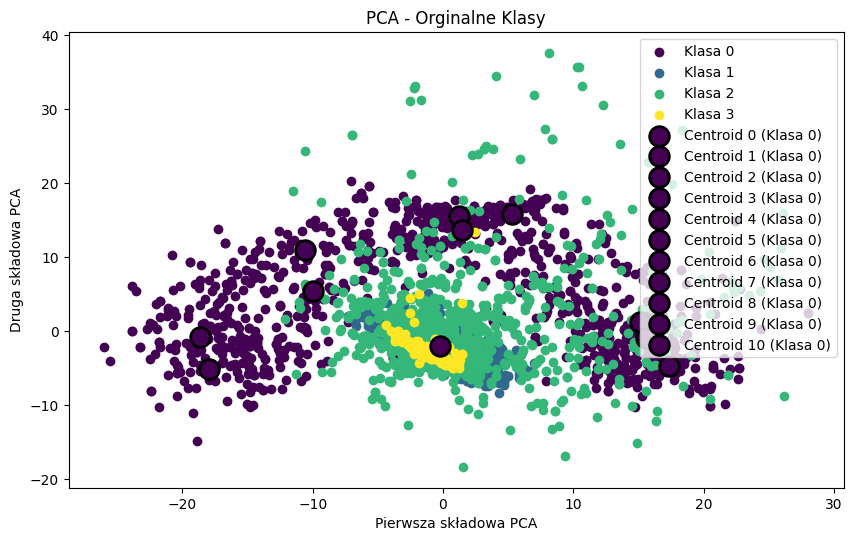

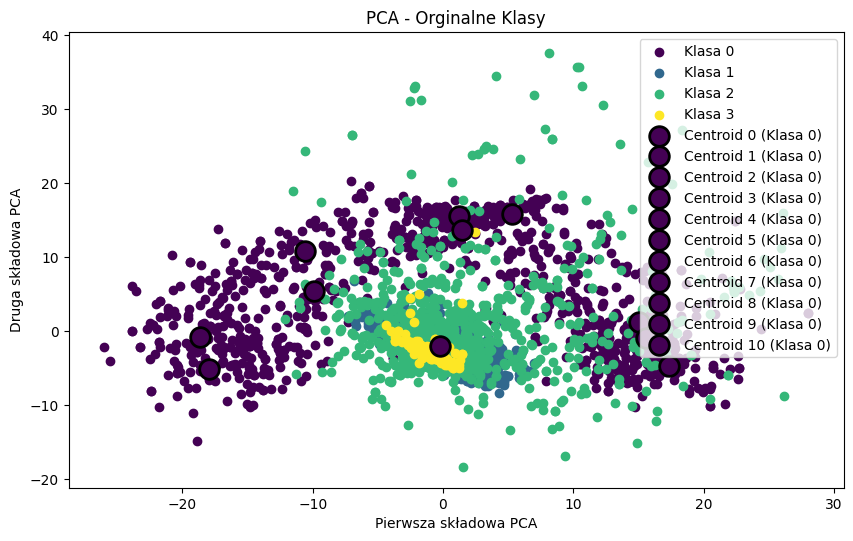

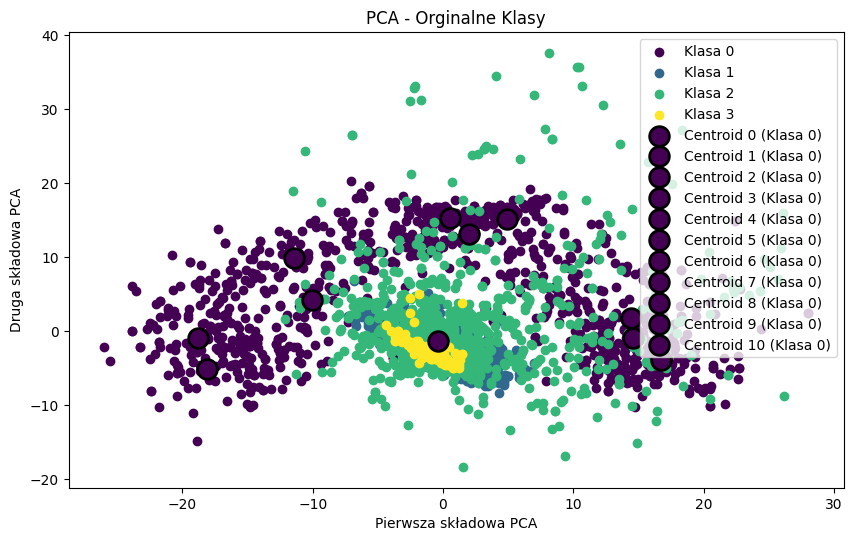

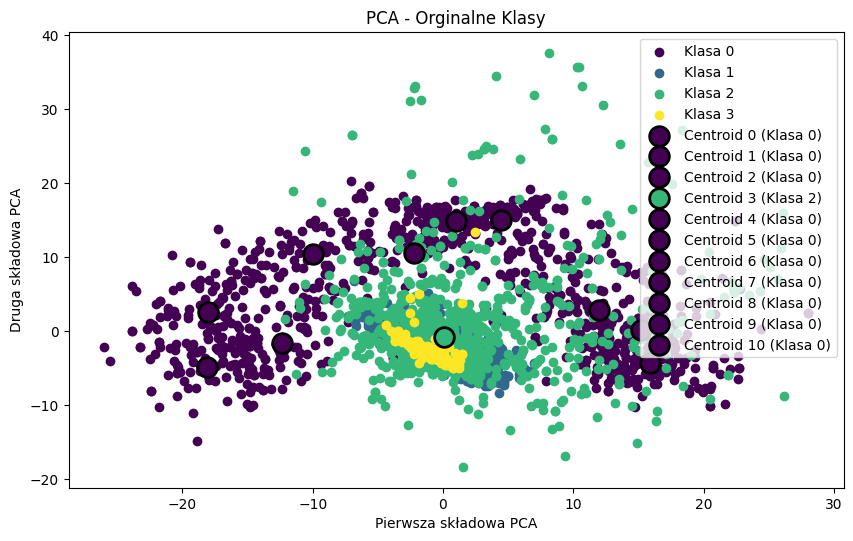

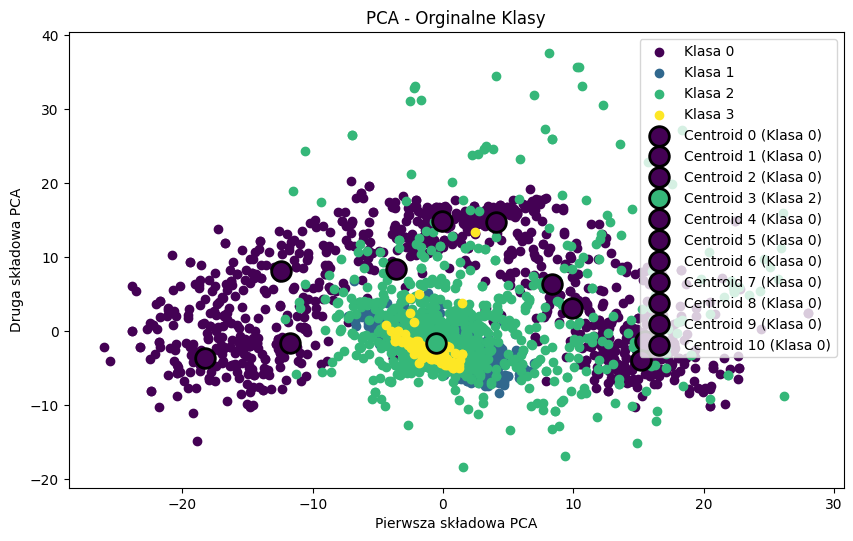

In [46]:
import tkinter as tk
from tkinter import ttk
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinterweb import HtmlFrame
import plotly.graph_objects as go
from libraries.IFCM import create_labels
import mplcursors

class Controller(object):
    pass

ifcm_caller = Controller()
ifcm_caller.centroids = None
ifcm_caller.itr = 0
ifcm_caller.diagnosis_tools = DiagnosisTools()
ifcm_caller.diagnosis_iterations = []
ifcm_caller.dimensions = chunks[0].shape[1]
ifcm_caller.picked_dim = 0
ifcm_caller.validation_x = np.concatenate(chunks_test) 
ifcm_caller.validation_y = np.concatenate(chunks_test_y) 
ifcm_caller.current_plot = 1 
ifcm_caller.classify_chunks = False 
ifcm_caller.val_y_predicted = None 
ifcm_caller.val_y_predicted_before_vote = None 
ifcm_caller.diffrent_indices = None 
ifcm_caller.cluster_to_class = None 
ifcm_caller.fuzzy_labels_val = None 

def plot_pca_validation(validation_x, validation_y, centroids, n_classes, color_option, fuzzy_labels_val ,whole_data=None, centroids_to_class=None):
    # Rzutowanie danych na dwuwymiarową przestrzeń za pomocą PCA
    #print("fuzzy_labels_val.shape[1]", fuzzy_labels_val.shape[1])
    #print("validation_y.len", len(validation_y))
    pca = PCA(n_components=2)
    print(fuzzy_labels_val[:,0])
    #print("dlugosc ",len(fuzzy_labels_val[:,0]))

    if whole_data is not None:
        pca.fit(whole_data)  # Dopasowanie PCA do całego zbioru danych
    else:
        pca.fit(validation_x)  # Dopasowanie PCA tylko do zbioru walidacyjnego
    
    reduced_data = pca.transform(validation_x)  # Transformacja zbioru walidacyjnego
    reduced_centroids = pca.transform(centroids)  # Transformacja centroidów
    
    for widget in plot_frame.winfo_children():
        widget.destroy()
    
    # Tworzenie wykresu
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Kolory do rysowania danych dla każdej klasy
    colors = plt.cm.get_cmap('viridis', n_classes)
    
    # Lista do przechowywania scatter plotów
    scatter_plots = []
    description = []
    # Rysowanie danych dla każdej klasy osobno
    for class_idx in range(n_classes):
        class_mask = validation_y == class_idx
        #print(fuzzy_labels_val[:, class_mask])
        for i in range(fuzzy_labels_val.shape[1]):
            if class_mask[i]:  # Sprawdzamy, czy maska dla tego indeksu jest prawdziwa
                #for value in fuzzy_labels_val[:, i]:
                description.append(fuzzy_labels_val[:, i])

        scatter = ax.scatter(reduced_data[class_mask, 0], reduced_data[class_mask, 1], 
                   color=colors(class_idx), label=f'Klasa {class_idx}')
        scatter_plots.append(scatter)
    
    # Rysowanie centroidów z kolorowaniem według przypisanej klasy i czarnym obramowaniem
    if centroids_to_class is not None:
        for idx, (centroid, class_idx) in enumerate(zip(reduced_centroids, centroids_to_class)):
            ax.scatter(centroid[0], centroid[1], 
                       color=colors(class_idx), edgecolor='black', 
                       marker='o', s=200, linewidths=2, label=f'Centroid {idx} (Klasa {class_idx})')
    
    # Dodanie legendy
    ax.legend()
    
    # Dodanie tytułu i etykiet osi
    ax.set_title(f'PCA - {color_option}')
    ax.set_xlabel('Pierwsza składowa PCA')
    ax.set_ylabel('Druga składowa PCA')
    
    # Użycie mplcursors do dodania interaktywnych etykiet
    # def hover_label(sel):
    #     sel.annotation.set_text(f'przyanleznosci: {description[sel.index]}')
    #print("--------------------aaaaaaaaaaaaaaaaaaaaaaaaaaaaa")
    #print(description[3])    
    def hover_label(sel):
        text = ''
        #for i in description[sel.index]:
        print(description[sel.index])
        k = 0
        for i in description[sel.index]:
            text += (f"u do centorida {k} wynosi: {i:.3f}\n")
            k += 1
        sel.annotation.set_text(text)
           
    mplcursors.cursor(scatter_plots, hover=True).connect("add", hover_label)
    
    # Wyświetlanie wykresu w tkinter
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()


def update_number():
    number_label.config(text=f"Liczba iteracji: {ifcm_caller.itr} / {len(chunks)}")

def process_iteration(root, plot_frame):
    if ifcm_caller.itr < len(chunks):
        silhouette_avg, davies_bouldin_avg, fpc_test, rand, new_centroids, fuzzy_labels, statistics = run_algorithm(n_clusters, chunks, chunks_test, chunks_test_y, False, plot_tsne, 'euclidean',  ifcm_caller.centroids, ifcm_caller.itr)
        
        #ifcm_caller.diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        #ifcm_caller.diagnosis_tools.add_centroids(new_centroids)
        #ifcm_caller.diagnosis_iterations.append(statistics)

        ifcm_caller.centroids = new_centroids
        ifcm_caller.itr =  ifcm_caller.itr + 1
        
        trained_x = np.concatenate(chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks[0]
        trained_y = np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks_y[0]
        
        n_classess =  len(np.unique(ifcm_caller.validation_y))
        #print("y: ",len(ifcm_caller.validation_y))
        #print(ifcm_caller.validation_x.shape)
       
        validation_y_predicted, validation_y_before_major, validation_y_chunked, cluster_to_class, fuzzy_labels_val = classify_points_knn_eliminate_minor_class(trained_x, trained_y, ifcm_caller.validation_x, ifcm_caller.validation_y, new_centroids, 'euclidean', m, n_classess, ifcm_caller.classify_chunks, chunks_test)

        confusion_matrix_val = confusion_matrix(ifcm_caller.validation_y, validation_y_predicted)
        print("macierz pomylek")
        print(confusion_matrix_val)
        
        ifcm_caller.cluster_to_class = cluster_to_class 
        ifcm_caller.cluster_to_class = cluster_to_class 
        
        ifcm_caller.fuzzy_labels_val = fuzzy_labels_val 
        #print("dlugosc predykcji",len(validation_y_predicted))
        ifcm_caller.val_y_predicted = validation_y_chunked 
        ifcm_caller.val_y_predicted_before_vote = validation_y_before_major 

        
        rozne_indeksy = [i for i in range(len(validation_y_chunked)) if not np.array_equal(validation_y_chunked[i], chunks_test_y[i])]
        ifcm_caller.diffrent_indices = rozne_indeksy
        
        if len(rozne_indeksy) > 0:
            print("Indeksy, gdzie tablice są różne:", rozne_indeksy)
            print("-----------------------------------------------------------------")
            for i in rozne_indeksy:
                pass
                #if rozne_indeksy[i] < len(chunks_test_y):
                    #print("prawidłowe", chunks_test_y[i])
                    #print("preydykcje", validation_y_chunked[i])
                    #print("preydykcje przed glosowanie", validation_y_before_major[i])
                    #print("")
        
        statistics = calculate_statistics(ifcm_caller.validation_y, validation_y_predicted)  
        print('Accuracy:' , statistics['Accuracy'])
        print('Precision: ', statistics['Precision'])
        print('Recall: ', statistics['Recall'])
        label.config(
            text=(
                f"Valdiation stats: \n"
                f"acc: {statistics['Accuracy']:.3f}\n"
                f"precision: {statistics['Precision']:.3f}\n"
                f"recall: {statistics['Recall']:.3f}"
            )
        )
        update_number()
        if ifcm_caller.current_plot == 1:
            show_pca(root, plot_frame)
        else:
            show_1_dimension()
    
def show_pca(root, plot_frame):
        data = None
        labels = None
        selected = color_points_option.get()
        n_classes = None
        option = None
        # podział na rodzaj danyh
        if switch_var.get():
            # validation
            data = ifcm_caller.validation_x
            if selected == "Original":
                labels = np.concatenate(chunks_test_y) 
                n_classes = len(np.unique(ifcm_caller.validation_y))
                option = "Orginalne Klasy"
                
            elif selected == "Classify":
                n_classes =  len(np.unique(ifcm_caller.validation_y))
                trained_x = np.concatenate(chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks[0]
                trained_y = np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks_y[0]
                labels, validation_y_before_major, validation_y_chunked, cluster_to_class, fuzzy_labels_val   = classify_points_knn_eliminate_minor_class(trained_x, trained_y, ifcm_caller.validation_x, ifcm_caller.validation_y, ifcm_caller.centroids, 'euclidean', m, n_classes, ifcm_caller.classify_chunks, chunks_test)
                option = "Klasyfikacja"
                ifcm_caller.fuzzy_labels_val = fuzzy_labels_val
                #print(np.unique(labels))
            elif selected == "Cluster":
                n_classes = len(ifcm_caller.centroids)
                fuzzy_labels = create_labels(ifcm_caller.validation_x, ifcm_caller.centroids, 'euclidean', m)
                labels = np.argmax(fuzzy_labels, axis=0)
                option = "przynależność do Klastrów"


        else:
            trained_x = np.concatenate(chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks[0]
            trained_x_chunks = (chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks[0]
            trained_y = np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks_y[0]
            data = trained_x
            
            if selected == "Original":
                labels = np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks_y[0]
                n_classes = len(np.unique(ifcm_caller.validation_y)) 
                option = "Orginalne Klasy"
                
            elif selected == "Classify":
                n_classes =  len(np.unique(ifcm_caller.validation_y))
                labels, validation_y_before_major, validation_y_chunked, cluster_to_class, fuzzy_labels_val  = classify_points_knn_eliminate_minor_class(trained_x, trained_y, trained_x, trained_y, ifcm_caller.centroids, 'euclidean', m, n_classes, ifcm_caller.classify_chunks, trained_x_chunks)
                n_classes = len(np.unique(ifcm_caller.validation_y))
                option = "Klasyfikacja"
                
            elif selected == "Cluster":
                fuzzy_labels = create_labels(trained_x, ifcm_caller.centroids, 'euclidean', m)
                labels = np.argmax(fuzzy_labels, axis=0)
                n_classes = len(ifcm_caller.centroids)
                option = "przynależność do Klastrów"
                
        plot_pca_validation(data, labels, ifcm_caller.centroids, n_classes, option, ifcm_caller.fuzzy_labels_val, centroids_to_class = ifcm_caller.cluster_to_class )
        ifcm_caller.current_plot = 1

        

def run_algorithm(n_clusters, chunks, validation_data, validation_y, visualise_data=False, plot_func=plot_pca, metric='euclidean', centroids = None, itr = 0):
    data = np.concatenate(chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 0 else chunks[0]
    y_supervised =  np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 0 else chunks_y[0]
    #data = chunks[itr]
    #y_supervised = chunks_y[itr]

    #centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_semi_supervised_fuzzy_cmeans(data, y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=centroids)

    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids)
    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, validation_y, m, g_error)
    print(itr)

    return silhouette_avg, davies_bouldin_avg, fpc_test, rand, centroids, fuzzy_labels , statistics     


def show_mistakes():
        selected_chunks = [chunks_test[i] for i in ifcm_caller.diffrent_indices]
        #fuzzy_labels_val = create_labels(validation_x, centroids, metric, m)

        selected_chunks_fuzzy = [create_labels(chunks_test[k], ifcm_caller.centroids, 'euclidean', m) for k in ifcm_caller.diffrent_indices]
        data = np.concatenate(selected_chunks)
        
        fuzzy_labels_val = np.concatenate(selected_chunks_fuzzy, axis = 1)
        print("fuzzy_labels_val", fuzzy_labels_val.shape)
        labels = None
        selected = color_points_option.get()
        n_classes = None
        option = None
        if selected == "Original":
                selected_chunks = [chunks_test_y[i] for i in ifcm_caller.diffrent_indices]
                labels = np.concatenate(selected_chunks)
                n_classes = len(np.unique(ifcm_caller.validation_y))
                option = "Orginalne Klasy"
                
        elif selected == "Classify":
                n_classes =  len(np.unique(ifcm_caller.validation_y))

            
                trained_x = np.concatenate(chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks[0]
                trained_y = np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks_y[0]
                validation_y_predicted, validation_y_before_major, validation_y_chunked, cluster_to_class, fuzzy_labels_val_notuse = classify_points_knn_eliminate_minor_class(trained_x, trained_y, ifcm_caller.validation_x, ifcm_caller.validation_y, ifcm_caller.centroids, 'euclidean', m, n_classes, ifcm_caller.classify_chunks, chunks_test)
        
            
                selected_chunks = [validation_y_before_major[i] for i in ifcm_caller.diffrent_indices]
                labels = np.concatenate(selected_chunks)
                #labels = np.concatenate(ifcm_caller.val_y_predicted_before_vote[ifcm_caller.diffrent_indices])               
                option = "Klasyfikacja"
                #print(np.unique(labels))
        elif selected == "Cluster":
                n_classes =  len(np.unique(ifcm_caller.validation_y))
                selected_chunks = [ifcm_caller.val_y_predicted_before_vote[i] for i in ifcm_caller.diffrent_indices]
                labels = np.concatenate(selected_chunks)
                #labels = np.concatenate(ifcm_caller.val_y_predicted_before_vote[ifcm_caller.diffrent_indices])               
                option = "Przed glosowaniem wiekszosciowy"
                #print(np.unique(labels))

                
        plot_pca_validation(data, labels, ifcm_caller.centroids, n_classes, option, fuzzy_labels_val, ifcm_caller.validation_x, centroids_to_class = ifcm_caller.cluster_to_class )
        ifcm_caller.current_plot = 1

    
def update_dimensions(event):
    ifcm_caller.picked_dim = int(dimensions_combobox.get())
    print(f"Wybrano wymiar: { ifcm_caller.picked_dim}")
    show_1_dimension()

def on_checkbox_toggle():
    if enable_chunks_classifications.get():
        ifcm_caller.classify_chunks = True 
    else:
        ifcm_caller.classify_chunks = False 
        
    if ifcm_caller.current_plot == 1:
        show_pca(root, plot_frame)
    else:
        show_1_dimension()
        
def toggle():
    if switch_var.get():
        status_label.config(text="Validation")
    else:
        status_label.config(text="Train")
    show_pca(root, plot_frame)
   
# Tworzenie głównego okna
root = tk.Tk()
root.title("Aplikacja z przełącznikiem, przyciskiem i wykresem")

# Tworzenie ramki na przełącznik i przycisk
control_frame = tk.Frame(root)
control_frame.pack(side=tk.TOP, fill=tk.X, pady=10, padx=10)  # fill=tk.X rozciąga na szerokość, padx dodaje margines poziomy

plot_frame = tk.Frame(root, width=1000, height=800)  # Ustawienie stałych wymiarów
plot_frame.pack(side=tk.TOP, pady=20, fill=tk.BOTH, expand=True)

# Przełącznik (Checkbox)
var = tk.BooleanVar()

button = ttk.Button(control_frame, text="Show Mistakes",  command=lambda:  show_mistakes())
button.pack(side=tk.LEFT, padx=10)
# Przycisk
button = ttk.Button(control_frame, text="Show PCA",  command=lambda:  show_pca(root, plot_frame))
button.pack(side=tk.LEFT, padx=10)

button = ttk.Button(control_frame, text="Next iteration",  command=lambda:  process_iteration(root, plot_frame))
button.pack(side=tk.LEFT, padx=10)

number_label = ttk.Label(control_frame, text=f"Iteration Count:  {ifcm_caller.itr}", font=("Helvetica", 16))
number_label.pack(pady=20)

# dimensions_combobox = ttk.Combobox(control_frame, values=list(range(0, ifcm_caller.dimensions )), state="readonly")
# dimensions_combobox.set(0)  # Ustawienie domyślnej wartości
# dimensions_combobox.bind("<<ComboboxSelected>>", update_dimensions)
# dimensions_combobox.pack(side=tk.LEFT, padx=10)

enable_chunks_classifications = tk.BooleanVar()

checkbox = ttk.Checkbutton(control_frame, text="Classify whole chunks", variable=enable_chunks_classifications, command=on_checkbox_toggle)
checkbox.pack(side=tk.LEFT, padx=10)

# Zmienna przechowująca stan przełącznika
switch_var = tk.BooleanVar(value=False)

# Tworzenie przełącznika (Checkbutton)
toggle_switch = tk.Checkbutton(control_frame, text="Train data/Validation data", variable=switch_var, command=toggle)
toggle_switch.pack(pady=10)

# Etykieta do wyświetlania stanu przełącznika
status_label = tk.Label(control_frame, text="Train")
status_label.pack(pady=10)

################################################################################################################

                          ##Przełącznik Orignalnych klas \ Klasyfikacji\ Przynależnosci do Centroidów##

#################################################################################################################

def show_selection():
    selected = color_points_option.get()
    print(selected)
    show_pca(root, plot_frame)

# Zmienna przechowująca wybór
color_points_option = tk.StringVar(value="Original")

# Tworzenie przycisków radiowych
tk.Radiobutton(control_frame, text="Original Classes", variable = color_points_option, value="Original", command=show_selection).pack(anchor=tk.W)
tk.Radiobutton(control_frame, text="Classification Classes", variable = color_points_option, value="Classify", command=show_selection).pack(anchor=tk.W)
tk.Radiobutton(control_frame, text="Cluster Membership", variable = color_points_option, value="Cluster", command=show_selection).pack(anchor=tk.W)



################################################################################################################

                          ## Tekst ze statystykami

#################################################################################################################

label = tk.Label(control_frame, text="Valdiation stats: \n acc: \n precision: \n recall: ", font=("Arial", 14))
#label.pack(side=tk.RIGHT, padx=20, pady=20)

label.place(relx=0.9, rely=0.5, anchor='e', x=-10, y=0)  # relx=1.0 ustawia widget na prawo


# Start aplikacji
root.mainloop()


# Baseline Methods

## KNN - MSM

In [80]:
import numpy as np
from sktime.distances import msm_distance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested



In [81]:
class KNN_MSM(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=3, msm_cost=0.5):
        self.n_neighbors = n_neighbors
        self.msm_cost = msm_cost
        self.knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=self._msm_metric)
    
    def _msm_metric(self, X1, X2):
        # `X1` i `X2` to zagnieżdżone tablice (z 3D) 
        dist = 0
        for i in range(X1.shape[0]):  # Iteracja po wymiarach
            dist += msm_distance(X1[i], X2[i], c=self.msm_cost)
        return dist
    
    def fit(self, X, y):
        self.knn.fit(X, y)
        return self
    
    def predict(self, X):
        return self.knn.predict(X)
    
    def predict_proba(self, X):
        return self.knn.predict_proba(X)


In [82]:
knn_msm = KNN_MSM(n_neighbors=2, msm_cost=0.5)

# Trenowanie modelu
knn_msm.fit(from_3d_numpy_to_nested(np.concatenate(chunks)), from_3d_numpy_to_nested(np.concatenate(chunks_y)))

# Przewidywanie etykiet dla danych testowych
predictions = knn_msm.predict(from_3d_numpy_to_nested(np.concatenate(chunks_test)))
print(predictions)

ValueError: not enough values to unpack (expected 3, got 2)

In [87]:
import numpy as np

def msm_distance(x, y, cost=0.5):
    n = len(x)
    m = len(y)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    
    for i in range(1, n + 1):
        D[i, 0] = D[i-1, 0] + cost
    
    for j in range(1, m + 1):
        D[0, j] = D[0, j-1] + cost
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if x[i-1] == y[j-1]:
                d = 0
            else:
                d = abs(x[i-1] - y[j-1])
                
            D[i, j] = min(
                D[i-1, j] + cost,
                D[i, j-1] + cost,
                D[i-1, j-1] + d
            )
            
    return D[n, m]


In [88]:
from collections import Counter

class KNN_MSM:
    def __init__(self, n_neighbors=3, msm_cost=0.5):
        self.n_neighbors = n_neighbors
        self.msm_cost = msm_cost
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X_test):
        predictions = []
        for test_series in X_test:
            distances = [msm_distance(test_series, train_series, self.msm_cost) for train_series in self.X_train]
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = [self.y_train[i] for i in nearest_indices]
            predictions.append(Counter(nearest_labels).most_common(1)[0][0])
        return predictions


In [92]:

# Tworzenie modelu KNN
knn_msm = KNN_MSM(n_neighbors=2, msm_cost=0.5)

# Trenowanie modelu
knn_msm.fit(np.concatenate(chunks), np.concatenate(chunks_y))

# Przewidywanie etykiet dla danych testowych
predictions = knn_msm.predict(np.concatenate(chunks_test))
print(predictions)


KeyboardInterrupt: 